In [ ]:
import networkx as nx
import random
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.optimize import curve_fit
from tqdm import tqdm

import pandas as pd

# Загрузка данных

загрузим таблицу со статьями, т.к. в ней есть год публикации

In [68]:
data = pd.read_csv("../main_table.csv",  low_memory=False)

In [69]:
len(data)

5354309

уберем статьи где нет года

In [70]:
data = data[data['year'].notna()][['_id', 'year']]
data.rename(columns={"_id": "id_article"}, inplace=True)

видно,что есть еще кривые данные

In [71]:
data['year'].min(), data['year'].max()

(0.0, 9737.0)

понятно, что статей из будущего не должно быть. Надо найти адекватную минимальную дату

In [73]:
data = data[data['year']<=2022]

<AxesSubplot: >

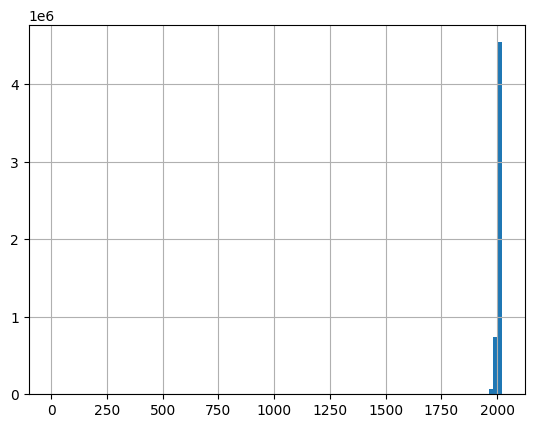

In [74]:
data['year'].hist(bins=100)

есть какие-то кривые данные около нуля. сделаем огрубое отсечение по 1000 году

array([[<AxesSubplot: title={'center': 'year'}>]], dtype=object)

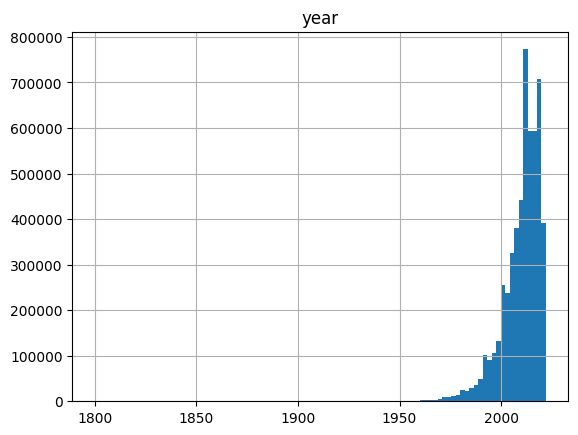

In [77]:
data[(data['year']>= 1000)].hist(bins=100)

видим, что самая ранняя дата теперь далеко от нашего отсечения, значит все ок

In [78]:
data = data[(data['year']>= 1000)]

In [81]:
len(data)

5353694

загрузим таблицу маппинга автора со статьей

In [16]:
authors = pd.read_csv("../db_map_article_authors.csv", low_memory=False)

In [18]:
len(authors)

13015526

найдем все пары соавторов по статьям неповторяющиеся внутри одной статьи

In [35]:
author_map = authors.join(authors.set_index('id_article'), on='id_article', how='left', lsuffix = '_l', rsuffix = '_r' )
author_map = author_map[author_map['id_author_l'] > author_map['id_author_r']]

соединим, чтобы в ней появился год публикации, после этого не нужен id_article

In [79]:
article=author_map.join(data.set_index('id_article'), on='id_article', how='inner')[['id_author_l', 'id_author_r', 'year']]

оставим только уникальные пары с минимальным годом

In [80]:
article.sort_values(by = 'year', inplace=True)

In [82]:
article.drop_duplicates(subset = ['id_author_l', 'id_author_r'], inplace=True, keep = 'first')

In [84]:
article.head()

,id_author_l,id_author_r,year
3171,53f47c90dabfaee43ed4a23b,53f43164dabfaee2a1cafa56,1907.0
12970,53f454fedabfaefedbb4b95d,53f440bfdabfaee0d9ba2480,1919.0
1589,53f4517edabfaee02ad460be,53f42f15dabfaee43ebdb1d7,1922.0
5981,53f45360dabfaee02ad4d54f,53f37ec3dabfae4b349ef56e,1922.0
5982,54090974dabfae8faa667d5e,53f45360dabfaee02ad4d54f,1922.0


посмотрим на года образование пар

<AxesSubplot: >

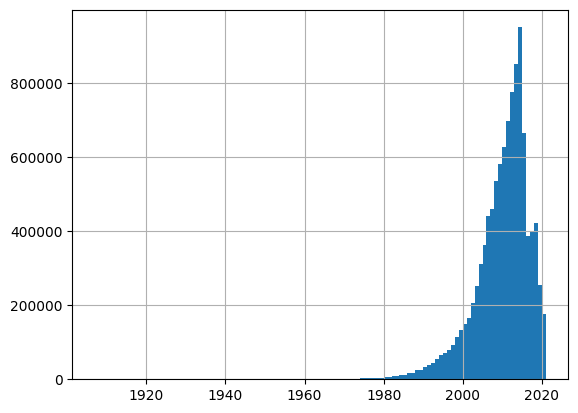

In [91]:
article['year'].hist(bins=int(article['year'].max()-article['year'].min()))

т.к. нам нужно будет рекомендовать соавтора, т.е. по сути предсказывать пояление новых связей, то логично поделить датасет на тет и трейн по году образования связи.

т.к. база выбла выгружена в мае 2021 года, то в ыделим в тест 2020 и 2021 год

In [100]:
len(article[article['year']>=2020])/len(article)

0.016797743462544805

1.7% связей попало в тест. Выглядит довольно не плохо

обучатся тоже надо будет с учетом времени образования связей, так что год оставим.

In [103]:
article[article['year']>=2020].to_csv('test.csv', index=False)
article[article['year']<2020].to_csv('train.csv', index=False)

В качестве метрики логично взять Mean average precision at K , т.к. по сути на выходе у нас дожен быть ограниченный  ранжированный список соавторов